In [1]:
#Import statements
from sqlalchemy import create_engine
import cx_Oracle
import pandas as pd
import numpy as np


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#Connect to oracle DB

host='localhost'
port=1521
sid='springboard'
user='springboard'
password='springboard123'
sid = cx_Oracle.makedsn(host, port, sid=sid)

cstr = 'oracle://{user}:{password}@{sid}'.format(
    user=user,
    password=password,
    sid=sid
)

engine =  create_engine(
    cstr,
    convert_unicode=False,
    pool_recycle=10,
    pool_size=50,
    echo=False
)


In [4]:
#Let's continue with our preliminary analysis of the data
#First let's find out which are the most common procedures

query2 = engine.execute('SELECT HCPCS_CODE, HCPCS_DESCRIPTION, COUNT(*) '
                        'FROM MEDICARECHARGESFINAL '
                        'WHERE HCPCS_CODE NOT LIKE {} '
                        'GROUP BY HCPCS_CODE, HCPCS_DESCRIPTION '
                        'HAVING COUNT(*) >= 10000 '
                        'ORDER BY COUNT(*) DESC '.format(("'99%'")))

df2 = pd.DataFrame(query2.fetchall())
df2.columns = query2.keys()
print(df2.head())   

  hcpcs_code                                  hcpcs_description  COUNT(*)
0      G0008          Administration of influenza virus vaccine    140912
1      36415  Insertion of needle into vein for collection o...     93570
2      G0009             Administration of pneumococcal vaccine     89307
3      90662    Vaccine for influenza for injection into muscle     85351
4      93000  Routine EKG using at least 12 leads including ...     83106


In [5]:
#cpt_list - to be used in correlation calculation
#cpt_list_str - CPT codes to be used in query
# refinedList - formats cpt_list_str to be used inside SQL query

cpt_list = df2['hcpcs_code'].tolist()

df2['hcpcs_str'] = '\'' + df2['hcpcs_code'] + '\''
df2.hcpcs_str.head()



cpt_list_str = df2['hcpcs_str'].tolist()

refinedList = ','.join(a for a in cpt_list_str)

#values = list(zip(df2.hcpcs_description, df2.hcpcs_str))
#values

#refinedList

In [6]:
query3 = engine.execute('SELECT NPI,HCPCS_CODE, HCPCS_DESCRIPTION, ST_ABBR, FIPS_ST, FIPS_CO, '
                            'AVERAGE_SUBMITTED_CHRG_AMT AS AVG_CHARGES '
                            'FROM MEDICARECHARGESFINAL '
                            'WHERE HCPCS_CODE IN ({}) '.format(refinedList))
df3 = pd.DataFrame(query3.fetchall())
df3.columns = query3.keys()
print(df3.head(10)) 

          npi hcpcs_code                                  hcpcs_description  \
0  1003000134      88304  Pathology examination of tissue using a micros...   
1  1003000134      88305  Pathology examination of tissue using a micros...   
2  1003000134      88341  Special stained specimen slides to examine tissue   
3  1003000134      88342   Tissue or cell analysis by immunologic technique   
4  1003000407      36556  Insertion of central venous catheter for infus...   
5  1003000423      76830                   Ultrasound pelvis through vagina   
6  1003000423      G0101  Cervical or vaginal cancer screening; pelvic a...   
7  1003000423      Q0091  Screening papanicolaou smear; obtaining, prepa...   
8  1003000522      83036                               Hemoglobin A1C level   
9  1003000522      90662    Vaccine for influenza for injection into muscle   

  st_abbr fips_st fips_co   avg_charges  
0      IL      17     031           115  
1      IL      17     031           170  
2   

In [19]:
#df3.to_csv('data/MedicareChargesDataCorr.csv',index = None)

In [7]:
#Close DB connection
conn = engine.connect()
conn.close()

In [8]:
#Add FIPS column & convert avg_charges to floats
df3['FIPS'] = df3['fips_st'] + df3['fips_co']
df3['avg_charges'] = pd.to_numeric(df3.avg_charges, downcast='float')
df3.head()


,npi,hcpcs_code,hcpcs_description,st_abbr,fips_st,fips_co,avg_charges,FIPS
0,1003000134,88304,Pathology examination of tissue using a micros...,IL,17,031,115.0,17031
1,1003000134,88305,Pathology examination of tissue using a micros...,IL,17,031,170.0,17031
2,1003000134,88341,Special stained specimen slides to examine tissue,IL,17,031,68.0,17031
3,1003000134,88342,Tissue or cell analysis by immunologic technique,IL,17,031,147.0,17031
4,1003000407,36556,Insertion of central venous catheter for infus...,PA,42,021,621.0,42021


In [10]:
#Import demographics data into dataframe

demo_data = pd.read_csv('data/DemographicData2016.csv', dtype ='str')
demo_data.head(10)


,FIPS,State,County,Median_income,Population,Perc_over_65
0,01001,Alabama,Autauga,54487,55416,14.7
1,01003,Alabama,Baldwin,56460,208563,19.7
2,01005,Alabama,Barbour,32884,25965,18
3,01007,Alabama,Bibb,43079,22643,15.4
4,01009,Alabama,Blount,47213,57704,18
5,01011,Alabama,Bullock,34278,10362,16.3
6,01013,Alabama,Butler,35409,19998,19
7,01015,Alabama,Calhoun,41778,114611,16.9
8,01017,Alabama,Chambers,39530,33843,19.1
9,01019,Alabama,Cherokee,41456,25725,22


In [11]:
demo_data['Median_income'] = pd.to_numeric(demo_data.Median_income, downcast='float')
demo_data['Population'] = pd.to_numeric(demo_data.Population)
demo_data['Perc_over_65'] = pd.to_numeric(demo_data.Perc_over_65, downcast='float')
demo_data.head()

,FIPS,State,County,Median_income,Population,Perc_over_65
0,01001,Alabama,Autauga,54487.0,55416,14.700000
1,01003,Alabama,Baldwin,56460.0,208563,19.700001
2,01005,Alabama,Barbour,32884.0,25965,18.000000
3,01007,Alabama,Bibb,43079.0,22643,15.400000
4,01009,Alabama,Blount,47213.0,57704,18.000000


In [12]:
#function to get dataframe with average charges and FIPS data
def get_avg_charges_FIPS(data,cpt):
    data_sel = data[data.hcpcs_code==cpt]
    data_avg_FIPS =data_sel[['FIPS','avg_charges']]
    return data_avg_FIPS


data_test = get_avg_charges_FIPS(df3,'G0444')

data_test.head()


,FIPS,avg_charges
1220,13073,50.0
2018,48113,50.0
2058,54011,32.0
3423,48113,25.0
3801,39095,53.0


In [13]:
#function to group dataframe with average charges and FIPS data by FIPS code
def group_avg_charges_FIPS(data):
    data_grouped = data.groupby('FIPS',as_index=False)['avg_charges'].median()
    return data_grouped


data_group_test = group_avg_charges_FIPS(data_test)

print(data_group_test)

       FIPS  avg_charges
0     01003    20.000000
1     01009    30.000000
2     01015    25.000000
3     01019    30.000000
4     01021    20.000000
5     01027    25.000000
6     01031    19.439999
7     01033    25.000000
8     01045    22.000000
9     01047    21.000000
10    01049    20.000000
11    01051    21.000000
12    01053    22.000000
13    01055    30.000000
14    01069    22.000000
15    01071    28.888889
16    01073    26.000000
17    01077    26.000000
18    01081    75.000000
19    01083    30.000000
20    01087    21.000000
21    01089    25.784554
22    01097    33.000000
23    01101    25.000000
24    01103    25.000000
25    01107    27.500000
26    01111    35.000000
27    01113    75.000000
28    01115    19.712999
29    01117    26.000000
...     ...          ...
1082  55017    25.000000
1083  55021    15.000000
1084  55025    27.252941
1085  55027    20.000000
1086  55059    52.000000
1087  55063    35.530998
1088  55079    76.000000
1089  55089    76.000000


In [14]:
#Function to merge avg_charges and demographics counts and get correlation dataset
def get_correlation_dataset(data_charges,data_demo):
    corr_data = pd.merge(data_charges[['FIPS','avg_charges']], data_demo[['FIPS','Median_income','Population','Perc_over_65']], on='FIPS')
    corr_data.set_index('FIPS', inplace=True)
    return corr_data

correl_dataset = get_correlation_dataset(data_group_test,demo_data)
print(correl_dataset)

       avg_charges  Median_income  Population  Perc_over_65
FIPS                                                       
01003    20.000000        56460.0      208563     19.700001
01009    30.000000        47213.0       57704     18.000000
01015    25.000000        41778.0      114611     16.900000
01019    30.000000        41456.0       25725     22.000000
01021    20.000000        44188.0       43941     16.100000
01027    25.000000        38512.0       13492     20.700001
01031    19.439999        48632.0       51226     16.400000
01033    25.000000        46572.0       54216     19.200001
01045    22.000000        40523.0       49226     16.200001
01047    21.000000        30488.0       40008     16.799999
01049    20.000000        37128.0       70900     16.400000
01051    21.000000        54553.0       81799     14.800000
01053    22.000000        35096.0       37728     17.200001
01055    30.000000        40972.0      102564     18.200001
01069    22.000000        42910.0      1

In [15]:
correlation = correl_dataset['avg_charges'].corr(correl_dataset['Perc_over_65'])
print(correlation)
#correl_dataset.corr()

-0.057558498967864594


In [16]:
def generate_corr_dict(data,demographics_data,cpt_list):
    median_inc_corr_dict = {}
    popul_corr_dict = {}
    over65_corr_dict = {}
    for cpt in cpt_list:
        avg_charges_data = get_avg_charges_FIPS(data,cpt)
        grouped_charges_data = group_avg_charges_FIPS(avg_charges_data)
        correl_data = get_correlation_dataset(grouped_charges_data,demographics_data)
        #Calculate correlation between avg charges and median income
        correl_med_income = correl_data['avg_charges'].corr(correl_data['Median_income'])
        median_inc_corr_dict[cpt]=correl_med_income
        #Calculate correlation between avg charges and county population
        correl_popul = correl_data['avg_charges'].corr(correl_data['Population'])
        popul_corr_dict[cpt]=correl_popul
        #Calculate correlation between avg charges and # population over 65
        correl_over65 = correl_data['avg_charges'].corr(correl_data['Perc_over_65'])
        over65_corr_dict[cpt]=correl_over65
    return (median_inc_corr_dict, popul_corr_dict, over65_corr_dict)     

median_dict, population_dict, over65_dict = generate_corr_dict(df3,demo_data,cpt_list)

#print(test_dict1)

In [20]:
print(len(population_dict))
#corr_df = pd.DataFrame(test_dict.items())
#corr_df.head(10)

160


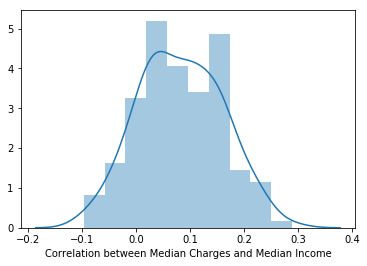

In [22]:
#Plot Median Income vs Avg Charges correlation

x = pd.Series(list(median_dict.values()), name="Correlation between Median Charges and Median Income")

#print(x)
ax = sns.distplot(x)

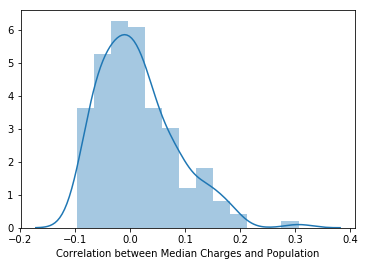

In [23]:
#Plot Population vs Avg Charges correlation

y = pd.Series(list(population_dict.values()), name="Correlation between Median Charges and Population")

ax = sns.distplot(y)

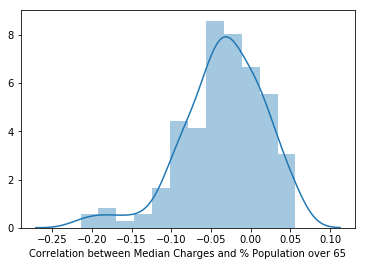

In [24]:
#Plot % Population over 65 vs Avg Charges correlation

z = pd.Series(list(over65_dict.values()), name="Correlation between Median Charges and % Population over 65")

ax = sns.distplot(z)